Archivo 'eaf_features.csv' cargado exitosamente.
Dimensiones del DataFrame: (20812, 69)

Datos preparados para el modelado. Número de características: 68

Calculando el Criterio de Información Bayesiano (BIC)...


c:\Users\rprie\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rprie\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\rprie\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rprie\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\rprie\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

Gráfico de BIC guardado como 'bic_scores_plot.png'
El número óptimo de componentes según BIC es: 12

Entrenando el modelo GMM final con 12 componentes...
Modelo GMM entrenado.
Umbral de anomalía (log-likelihood): 115.16

Número total de anomalías detectadas: 1041

--- Comparación de Características (Anómalos vs. Normales) ---
                                Media de ciclos normales  \
Scrap 3B22                                      0.000000   
CCM 03-10mm                                     0.000000   
KShU 75                                         0.000000   
KRS-65                                          0.000000   
26A                                             0.000000   
Magnesite brick scrap                           0.000000   
FeSi 45                                         0.000000   
FeCr025                                         0.000000   
FeCr 850A                                       0.000000   
Vanadium alloy                                  0.000000   
CCM 30-60 mm

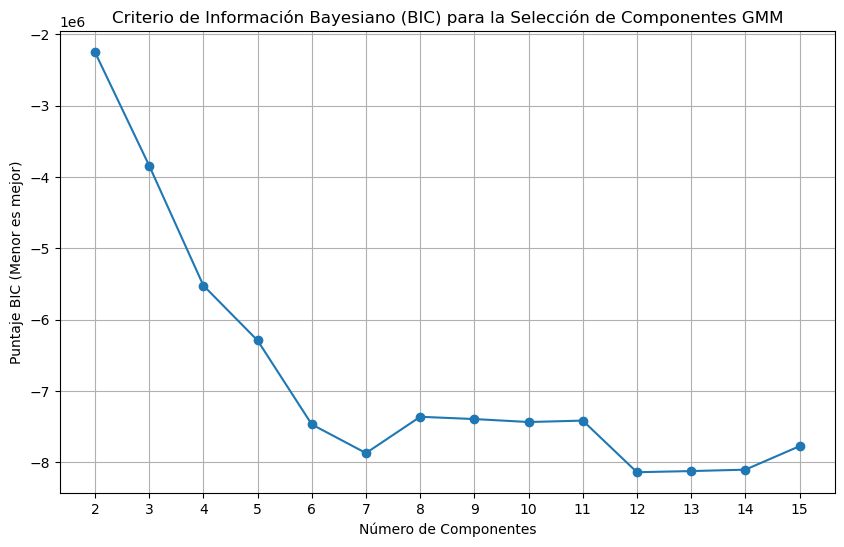

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# --- 1. Cargar el conjunto de datos de características ---
# Asegúrate de tener el archivo 'eaf_features.csv' generado en el paso anterior.
try:
    features_df = pd.read_csv('eaf_features.csv')
    print("Archivo 'eaf_features.csv' cargado exitosamente.")
    print(f"Dimensiones del DataFrame: {features_df.shape}")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'eaf_features.csv'.")
    exit()

# --- 2. Preparación de los Datos ---

# Guardar los HEATID para referencia futura
heat_ids = features_df['HEATID']
# Excluir HEATID de los datos para el modelo
X = features_df.drop('HEATID', axis=1)

# Imputar valores faltantes (NaN) usando la media
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"\nDatos preparados para el modelado. Número de características: {X_scaled.shape[1]}")

# --- 3. Encontrar el Número Óptimo de Componentes con BIC ---

print("\nCalculando el Criterio de Información Bayesiano (BIC)...")
n_components_range = range(2, 16)
bic_scores = []
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type='full', reg_covar=1e-05)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

# Graficar los puntajes BIC
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('Criterio de Información Bayesiano (BIC) para la Selección de Componentes GMM')
plt.xlabel('Número de Componentes')
plt.ylabel('Puntaje BIC (Menor es mejor)')
plt.xticks(n_components_range)
plt.grid(True)
plt.savefig('bic_scores_plot.png')
print("Gráfico de BIC guardado como 'bic_scores_plot.png'")

# Encontrar el número óptimo de componentes
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f"El número óptimo de componentes según BIC es: {optimal_n_components}")

# --- 4. Entrenar el Modelo GMM Final ---
print(f"\nEntrenando el modelo GMM final con {optimal_n_components} componentes...")
final_gmm = GaussianMixture(n_components=optimal_n_components, random_state=42, covariance_type='full', reg_covar=1e-05)
final_gmm.fit(X_scaled)
print("Modelo GMM entrenado.")

# --- 5. Detección de Anomalías ---
log_likelihoods = final_gmm.score_samples(X_scaled)
results_df = features_df.copy()
results_df['log_likelihood'] = log_likelihoods

# Definir un umbral (el 5% de los datos con menor probabilidad)
anomaly_threshold = np.quantile(log_likelihoods, 0.05)
results_df['is_anomaly'] = results_df['log_likelihood'] < anomaly_threshold
print(f"Umbral de anomalía (log-likelihood): {anomaly_threshold:.2f}")

# --- 6. Análisis de los Resultados ---
num_anomalies = results_df['is_anomaly'].sum()
print(f"\nNúmero total de anomalías detectadas: {num_anomalies}")

# Comparar las características
normal_cycles = results_df[results_df['is_anomaly'] == False].drop(['HEATID', 'is_anomaly', 'log_likelihood'], axis=1)
anomalous_cycles = results_df[results_df['is_anomaly'] == True].drop(['HEATID', 'is_anomaly', 'log_likelihood'], axis=1)
comparison = pd.DataFrame({
    'Media de ciclos normales': normal_cycles.mean(),
    'Media de ciclos anómalos': anomalous_cycles.mean()
})
comparison['diferencia_%'] = 100 * (comparison['Media de ciclos anómalos'] - comparison['Media de ciclos normales']) / comparison['Media de ciclos normales']
significant_diff = comparison[abs(comparison['diferencia_%']) > 20].sort_values('diferencia_%', ascending=False)

print("\n--- Comparación de Características (Anómalos vs. Normales) ---")
print(significant_diff)

print("\n--- Top 5 Anomalías Más Destacadas ---")
print(results_df.sort_values('log_likelihood').head(5))

# --- 7. Guardar Resultados ---
results_df.to_csv('eaf_anomalies_results.csv', index=False)
print("\nResultados completos guardados en 'eaf_anomalies_results.csv'.")